This file should be placed inside detectron2/projects/DensePose/ for correct imports. 
Link to the densepose2 framework: 
https://github.com/facebookresearch/detectron2

In [1]:
from detectron2.config import get_cfg
from detectron2.engine.defaults import DefaultPredictor
from detectron2.modeling import build_model
from densepose import add_densepose_config, add_hrnet_config
from detectron2.checkpoint import DetectionCheckpointer

In [2]:
# Load densepose model with learned weights
cfg = get_cfg()
add_densepose_config(cfg)
add_hrnet_config(cfg)

cfg.merge_from_file("configs/densepose_rcnn_R_50_FPN_s1x.yaml")

cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl"
cfg.freeze()
model = build_model(cfg)
model.eval()
checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

{'__author__': 'Detectron2 Model Zoo'}

In [3]:
type(model)

detectron2.modeling.meta_arch.rcnn.GeneralizedRCNN

In [4]:
model

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [5]:
import detectron2
b = model.backbone
b
type(b)
# ??detectron2.modeling.backbone.fpn.FPN

detectron2.modeling.backbone.fpn.FPN

In [6]:
# print(str(cfg))

In [7]:
import torch
from torch.nn import AdaptiveAvgPool2d
from torch.nn import Linear, Module
from torch.nn.functional import softmax
from torch.nn.functional import relu
from torch.nn import BatchNorm1d

In [8]:
# Check what the backbone from the original model returns
img = torch.zeros(size=(1, 3, 480, 640)).cuda()
out = b(img)
for k, v in out.items():
    print(k, v.size())

# Get the output with the smallest resolution and squash it to 2d    
a = AdaptiveAvgPool2d((1, 1))
squashed = a(out['p6'])
print(squashed.size())
reshaped = squashed.view((-1, 256))
print(reshaped.size())

p2 torch.Size([1, 256, 120, 160])
p3 torch.Size([1, 256, 60, 80])
p4 torch.Size([1, 256, 30, 40])
p5 torch.Size([1, 256, 15, 20])
p6 torch.Size([1, 256, 8, 10])
torch.Size([1, 256, 1, 1])
torch.Size([1, 256])


In [9]:
# Define yoga model with the backbone from dense pose
class YogaPoseEstimatorModel(Module):
    def __init__(self, backbone, num_classes, pixel_mean, pixel_std):
        super().__init__()
        self.backbone = backbone
        self.avg_pool = AdaptiveAvgPool2d((1, 1))
        self.fc1 = Linear(256, 64)
        self.bn1 = BatchNorm1d(64)
        self.fc2 = Linear(64, num_classes)
        self.pixel_mean = pixel_mean
        self.pixel_std = pixel_std
    
    def forward(self, x):
        x = self.preprocess(x)
        x = self.backbone(x)['p6']
        x = self.avg_pool(x)
        x = x.view((-1, 256))
        x = self.fc1(x)
        x = self.bn1(x)
        x = relu(x)
        x = self.fc2(x)
        x = softmax(x, dim=1)
        return x
    
    def preprocess(self, tensor):
        # Preprocessing from the source code for the original model
        tensor = (tensor - self.pixel_mean) / self.pixel_std
        return tensor

In [10]:
# We have 10 classes for simple yoga dataset
# pixel_mean and pixel_std parameters from the original model
my_model = YogaPoseEstimatorModel(model.backbone, 10, model.pixel_mean, model.pixel_std)
my_model.cuda()
print(my_model.pixel_mean)
print(my_model.pixel_std)

tensor([[[103.5300]],

        [[116.2800]],

        [[123.6750]]], device='cuda:0')
tensor([[[1.]],

        [[1.]],

        [[1.]]], device='cuda:0')


In [11]:
from detectron2.data.detection_utils import read_image

In [12]:
img = read_image('/home/ubuntu/SimpleYogaDataset/training_set/downwarddog/File18.jpg', format='BGR')

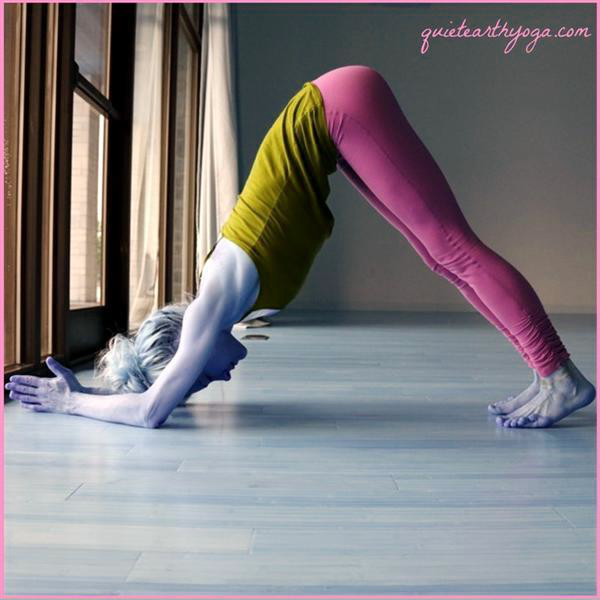

In [13]:
import numpy as np
from PIL import Image
Image.fromarray(img)

In [14]:
import os
from torch.utils.data import Dataset, DataLoader

In [15]:
class YogaDataset(Dataset):
    def __init__(self, image_dir):
        super().__init__()
        
        class_names = os.listdir(image_dir)
        self.all_classes = sorted([c for c in class_names if not c.startswith('.')])
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.all_classes)}
        
        self.data = []
        for class_name in self.all_classes:
            filenames = os.listdir(os.path.join(image_dir, class_name))
            filenames = [f for f in filenames if f.endswith('.jpg')]
            for filename in filenames:
                self.data.append((os.path.join(image_dir, class_name, filename), class_name))
    
    def __getitem__(self, idx):
        image_path, class_name = self.data[idx]
        
        image = read_image(image_path, format='BGR')
        height, width, _ = image.shape
        transform = detectron2.data.transforms.transform.ResizeTransform(h=height, w=width, new_h=800, new_w=800, interp=2)
        image = transform.apply_image(image)
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        
        class_idx = self.class_to_idx[class_name]
        return image, class_idx
    
    def __len__(self):
        return len(self.data)


In [16]:
train_set = YogaDataset('/home/ubuntu/SimpleYogaDataset/training_set')

In [17]:
print(len(train_set))
print(train_set.all_classes)
print(train_set.class_to_idx)
print(train_set.data[0])

696
['bridge', 'childs', 'downwarddog', 'mountain', 'plank', 'seatedforwardbend', 'tree', 'trianglepose', 'warrior1', 'warrior2']
{'bridge': 0, 'childs': 1, 'downwarddog': 2, 'mountain': 3, 'plank': 4, 'seatedforwardbend': 5, 'tree': 6, 'trianglepose': 7, 'warrior1': 8, 'warrior2': 9}
('/home/ubuntu/SimpleYogaDataset/training_set/bridge/File18.jpg', 'bridge')


In [18]:
data_loader = DataLoader(train_set, batch_size=16, shuffle=True, pin_memory=True)

Train the model

In [19]:
# Freeze the weights for densepose layers
for name, parameter in my_model.backbone.named_parameters():
    parameter.requires_grad = False

In [20]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

# Documentation: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, my_model.parameters()), lr=0.01)

In [21]:
print(len(list(my_model.parameters())))
print(len(list(filter(lambda p: p.requires_grad, model.parameters()))))

75
54


In [22]:
# for k, v in my_model.named_parameters():
#     print(k, v.sum().item(), v.requires_grad)

In [23]:
# Tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

my_model.train()
my_model.backbone.eval()

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(data_loader, 0):
        x, y = data
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        out = my_model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if True: #i % 10 == 9:    # print every 10 batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')
        
    

[1,     1] loss: 0.231
[1,     2] loss: 0.222
[1,     3] loss: 0.221
[1,     4] loss: 0.207
[1,     5] loss: 0.225
[1,     6] loss: 0.204
[1,     7] loss: 0.203
[1,     8] loss: 0.225
[1,     9] loss: 0.209
[1,    10] loss: 0.202
[1,    11] loss: 0.201
[1,    12] loss: 0.207
[1,    13] loss: 0.206
[1,    14] loss: 0.191
[1,    15] loss: 0.209
[1,    16] loss: 0.188
[1,    17] loss: 0.187
[1,    18] loss: 0.199
[1,    19] loss: 0.196
[1,    20] loss: 0.190
[1,    21] loss: 0.199
[1,    22] loss: 0.192
[1,    23] loss: 0.209
[1,    24] loss: 0.214
[1,    25] loss: 0.197
[1,    26] loss: 0.195
[1,    27] loss: 0.208
[1,    28] loss: 0.185
[1,    29] loss: 0.191
[1,    30] loss: 0.187
[1,    31] loss: 0.189
[1,    32] loss: 0.190
[1,    33] loss: 0.190
[1,    34] loss: 0.195
[1,    35] loss: 0.171
[1,    36] loss: 0.196
[1,    37] loss: 0.174
[1,    38] loss: 0.203
[1,    39] loss: 0.175
[1,    40] loss: 0.179
[1,    41] loss: 0.177
[1,    42] loss: 0.169
[1,    43] loss: 0.179
[1,    44] 

[9,     6] loss: 0.161
[9,     7] loss: 0.149
[9,     8] loss: 0.154
[9,     9] loss: 0.154
[9,    10] loss: 0.153
[9,    11] loss: 0.150
[9,    12] loss: 0.158
[9,    13] loss: 0.162
[9,    14] loss: 0.164
[9,    15] loss: 0.162
[9,    16] loss: 0.156
[9,    17] loss: 0.188
[9,    18] loss: 0.170
[9,    19] loss: 0.162
[9,    20] loss: 0.176
[9,    21] loss: 0.172
[9,    22] loss: 0.162
[9,    23] loss: 0.170
[9,    24] loss: 0.154
[9,    25] loss: 0.164
[9,    26] loss: 0.173
[9,    27] loss: 0.160
[9,    28] loss: 0.162
[9,    29] loss: 0.167
[9,    30] loss: 0.152
[9,    31] loss: 0.158
[9,    32] loss: 0.172
[9,    33] loss: 0.162
[9,    34] loss: 0.163
[9,    35] loss: 0.160
[9,    36] loss: 0.155
[9,    37] loss: 0.157
[9,    38] loss: 0.158
[9,    39] loss: 0.168
[9,    40] loss: 0.162
[9,    41] loss: 0.148
[9,    42] loss: 0.150
[9,    43] loss: 0.163
[9,    44] loss: 0.147
[10,     1] loss: 0.159
[10,     2] loss: 0.164
[10,     3] loss: 0.149
[10,     4] loss: 0.151
[10,   

In [24]:
# for k, v in my_model.named_parameters():
#     print(k, v.sum().item(), v.requires_grad)

In [25]:
PATH = './yoga_net.pth'
torch.save(my_model.state_dict(), PATH)

In [26]:
test_set = YogaDataset('/home/ubuntu/SimpleYogaDataset/test_set')
print(test_set.data[0])
print(test_set.data[1])

len(test_set)

('/home/ubuntu/SimpleYogaDataset/test_set/bridge/File7.jpg', 'bridge')
('/home/ubuntu/SimpleYogaDataset/test_set/bridge/File13.jpg', 'bridge')


105

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
import pickle


In [29]:
# Run on test set
test_loader = DataLoader(test_set, batch_size=16, shuffle=False, pin_memory=True)

correct = 0
total = 0

test_results = []

my_model.eval()
#pickle.dump(my_model, open("densepose_model.sav", 'wb'))
#my_model = pickle.load(open("densepose_model.sav", 'rb'))

with torch.no_grad():
    for data in test_loader:
        x, y = data
        x = x.cuda()
        y = y.cuda()
        out = my_model(x)
        _, predicted = torch.max(out.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum()
        for p in predicted.detach().cpu().numpy():
            test_results.append(p)

print(f'Accuracy of the network on the {total} test images: {100 * correct / total}%')

Accuracy of the network on the 105 test images: 80%


In [30]:
# Confusion matrix
nb_classes = 10
all_predicted = []
all_y = []
with torch.no_grad():
    for data in test_loader:
        x, y = data
        x = x.cuda()
        y = y.cuda()
        out = my_model(x)
        _, predicted = torch.max(out.data, 1)
        for p in predicted.detach().cpu().numpy():
            all_predicted.append(p)
        for g in y.detach().cpu().numpy():
            all_y.append(g)

confusion_matrix(all_predicted, all_y)


array([[ 9,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  9,  0,  0,  0,  5,  0,  0,  0,  0],
       [ 1,  0, 17,  3,  1,  1,  1,  0,  1,  0],
       [ 0,  0,  0, 27,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  4,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  4,  0,  0,  4,  1,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  6]])

In [31]:
import seaborn as sn
import matplotlib.pyplot as plt


cf = confusion_matrix(all_predicted, all_y)
vals = ['bridge', 'childs', 'downwarddog', 'mountain', 'plank', 'seatedforwardbend', 'tree', 'trianglepose', 'warrior1', 'warrior2']

df_cm = pd.DataFrame(cf_matrix, index = [i for i in vals],
                  columns = [i for i in vals])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

NameError: name 'pd' is not defined

In [ ]:
for i in range(len(test_set)):
    print(test_set.data[i], test_set.all_classes[test_results[i]])